## This is a basic Starter Kernel for the New York City Taxi Fare Prediction Playground Competition
Here we'll use a simple linear model based on the travel vector from the taxi's pickup location to dropoff location which predicts the fare_amount of each ride.

https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model

In [1]:
data_dir = '/Users/robin/kaggle/new-york-city-taxi-fare-prediction'

In [2]:
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to
%matplotlib inline

os.listdir(data_dir)

['test.csv',
 'GCP-Coupons-Instructions.rtf',
 'train.csv',
 'sample_submission.csv']

Data is quite large - train is 5.7 Gb, will max out memory if try to load it all so limit rows

In [3]:
train_df =  pd.read_csv(data_dir+'/train.csv', nrows = 10_000_000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

Let's create two new features in our training set representing the "travel vector" between the start and end points of the taxi ride, in both longitude and latitude coordinates. We'll take the absolute value since we're only interested in distance traveled. Use a helper function since we'll want to do the same thing for the test set later.


In [4]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

In [5]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754



Explore and prune outliers

First let's see if there are any NaNs in the dataset.

In [6]:
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


There are a small amount, so let's remove them from the dataset.

In [7]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999931


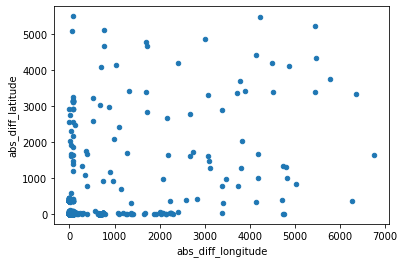

In [8]:
train_df.plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city. For reference, one degree of latitude is about 69 miles. However, we can see the dataset has extreme values which do not make sense. Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5


In [9]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999931
New size: 9979187


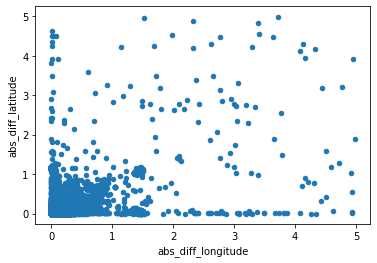

In [10]:
train_df.plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

## Train our model

Our model will take the form $X \cdot w = y$ where $X$ is a matrix of input features, and $y$ is a column of the target variable, fare_amount, for each row. The weight column $w$ is what we will "learn".

First let's setup our input matrix $X$ and target column $y$ from our training set. The matrix $X$ should consist of the two GPS coordinate differences, plus a third term of 1 to allow the model to learn a constant bias term. The column $y$ should consist of the target fare_amount values.

In [11]:
# Construct and return an Nx3 input matrix for our linear model
# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979187, 3)
(9979187,)


Now let's use numpy's [lstsq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) library function to find the optimal weight column $w$.

In [12]:
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[147.16176525  76.95503724   6.39545245]


These weights pass a quick sanity check, since we'd expect the first two values -- the weights for the absolute longitude and latitude differences -- to be positive, as more distance should imply a higher fare, and we'd expect the bias term to loosely represent the cost of a very short ride.

Sidenote: we can actually calculate the weight column $w$ directly using the Ordinary Least Squares method: $w = (X^T \cdot X)^{-1} \cdot X^T \cdot y$


In [13]:
w_OLS = np.matmul(np.matmul(np.linalg.inv(np.matmul(train_X.T, train_X)), train_X.T), train_y)
print(w_OLS)

[147.16176525  76.95503724   6.39545245]


## Make predictions on the test set

Now let's load up our test inputs and predict the fare_amounts for them using our learned weights!


In [14]:
test_df = pd.read_csv(data_dir+'/test.csv')

In [15]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)
# Predict fare_amount on the test set using our model (w) trained on the training set.
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])

submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.13
1,2015-01-27 13:08:24.0000003,9.69
2,2011-10-08 11:53:44.0000002,7.21
3,2012-12-01 21:12:12.0000002,9.01
4,2012-12-01 21:12:12.0000003,13.20


## Ideas for Improvement

The output here will score an RMSE of $5.74, but you can do better than that! Here are some suggestions:

* Use more columns from the input data. Here we're only using the start/end GPS points from columns [pickup|dropoff]_[latitude|longitude]. Try to see if the other columns -- pickup_datetime and passenger_count -- can help improve your results.
* Use absolute location data rather than relative. Here we're only looking at the difference between the start and end points, but maybe the actual values -- indicating where in NYC the taxi is traveling -- would be useful.
* Use a non-linear model to capture more intricacies within the data.
* Try to find more outliers to prune, or construct useful feature crosses.
* Use the entire dataset -- here we're only using about 20% of the training data!